In [11]:
import numpy as np
from numba import cuda
import matplotlib.pyplot as plt
from matplotlib.image import imread
import matplotlib.image as mpimg
from PIL import Image
import numpy as np

## Extra 9a: Historgram - Atomic

In [12]:
@cuda.jit
def local_histogram_kernel(image, local_histograms):
    """Calculate local histogram for each block"""
    # Shared memory for local histogram
    shared_hist = cuda.shared.array(shape=256, dtype=np.int32)
    
    # Thread indices
    tx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    ty = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y
    local_tid = cuda.threadIdx.y * cuda.blockDim.x + cuda.threadIdx.x
    block_id = cuda.blockIdx.y * cuda.gridDim.x + cuda.blockIdx.x
    
    # Initialize shared memory
    if local_tid < 256:
        shared_hist[local_tid] = 0
    cuda.syncthreads()
    
    # Each thread processes one pixel
    if tx < image.shape[1] and ty < image.shape[0]:
        # For grayscale image, we can directly use the pixel value
        cuda.atomic.add(shared_hist, image[ty, tx], 1)
    
    cuda.syncthreads()
    
    # Copy to global memory
    if local_tid < 256:
        local_histograms[block_id, local_tid] = shared_hist[local_tid]

@cuda.jit
def reduce_histogram_kernel(local_histograms, final_histogram):
    """Reduce all local histograms into the final histogram"""
    bin_idx = cuda.threadIdx.x  # Each thread handles one bin
    
    if bin_idx < 256:  # We have 256 bins for uint8 images
        total = 0
        # Sum up this bin across all local histograms
        for block_idx in range(local_histograms.shape[0]):
            total += local_histograms[block_idx, bin_idx]
        final_histogram[bin_idx] = total

Image shape: (427, 640)
Histogram sums to: 273280
First 10 bins: [ 611 1540  987  748  705  624  564  621  594  605]


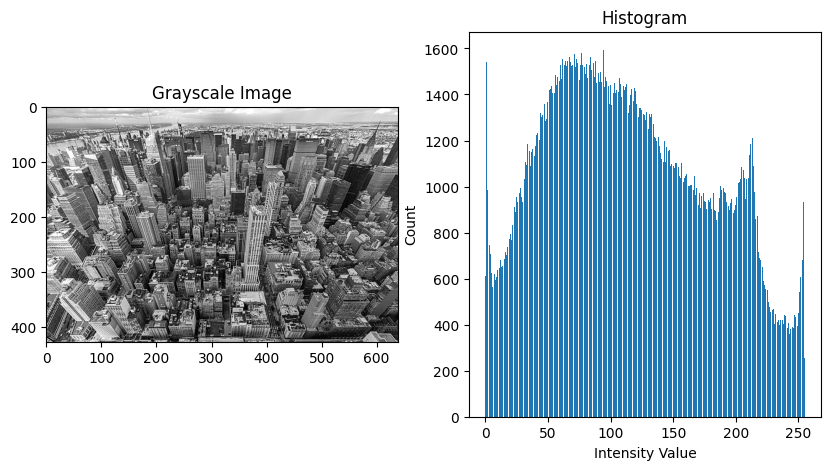

In [38]:
def calculate_histogram_atomic():
    #CPU to GPU
    #input = np.array(Image.open('gray.jpg'))
    #image = np.mean(input, axis=2).astype(np.uint8) # For fake conversion, right type!
    image = np.array(Image.open('input.jpg').convert('L'))
    d_image = cuda.to_device(image)
    
    # CPU asks GPU
    block_dim = (16, 16)  # 256 threads per block
    grid_dim = (
        (image.shape[1] + block_dim[0] - 1) // block_dim[0],
        (image.shape[0] + block_dim[1] - 1) // block_dim[1]
    )
    num_blocks = grid_dim[0] * grid_dim[1]
    
    # Allocate memory for histograms
    d_local_histograms = cuda.device_array((num_blocks, 256), dtype=np.int32)
    d_final_histogram = cuda.device_array(256, dtype=np.int32)
    
    # GPU processing
    local_histogram_kernel[grid_dim, block_dim](d_image, d_local_histograms)
    reduce_histogram_kernel[1, 256](d_local_histograms, d_final_histogram)
    
    # GPU to CPU
    histogram = d_final_histogram.copy_to_host()
    
    # Results
    print("Image shape:", image.shape)
    print("Histogram sums to:", histogram.sum())  # Should equal image size
    print("First 10 bins:", histogram[:10])
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.imshow(image, cmap='gray')
    plt.title('Grayscale Image')
    plt.subplot(122)
    plt.bar(range(256), histogram)
    plt.title('Histogram')
    plt.xlabel('Intensity Value')
    plt.ylabel('Count')
    plt.show()

calculate_histogram_atomic()